In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Описание данных и задачи
Предсказать получает ли человек больше суммы N или меньше.
- age: возраст, действительное.
- workclass: тип работодателя, категориальное. 
- final_weight: итоговый вес обьекта, действительное.
- education: уровень образования, категориальное.
- education-num: количество лет обучения, действительное.
- marital-status: семейное положение, категориальное.
- occupation: профессия, категориальное.
- relationship: тип семейных отношений, категориальное.
- race: раса, категориальное.
- sex: пол, категориальное.
- cap-gain: прирост капитала, действительное.
- cap-loss: потери капитала, действительное.
- hours-per-week: количество часов работы в неделю, действительное.
- native-country: страна, категориальное.

Целевая переменная: sum_N – уровень заработка, категориальный (бинарный) признак

#### Считаем csv файлы с тренировочной и тестовой выборкой и добавляем названия колонок

In [136]:
names = ['age', 'workclass', 'final_weight', 'education' , 'education-num', 
         'marital-status', 'occupation', 'relationship', 'race', 'sex', 'cap-gain', 
         'cap-loss', 'hours-per-week', 'native-country']
df_test = pd.read_csv("test_empty.txt", names=names)
names.append("sum_N")
df_train = pd.read_csv("data.txt", names=names)

#### Посмотрим наполнение датафреймов

In [137]:
df_train.head(5)

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,sum_N
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,<=N
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,<=N
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,<=N
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,<=N
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,<=N


In [138]:
df_test.head(5)

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States


#### Заменим значения таргета на бинарные, так как решаем задачу бинарной классификации

In [139]:
df_train['sum_N'] = df_train['sum_N'].replace({' <=N': 0, ' >N': 1})

In [140]:
df_train.head(5)

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,sum_N
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,0.0
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,0.0
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,0.0
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,0.0
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,0.0


# 2. Исследование данных
## а) Узнаём базовые сведения о тренировочном датасете

#### Сведения о размерах данных

In [141]:
df_train.shape

(32573, 15)

#### Информация о типах данных

In [142]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32573 non-null  object 
 1   workclass       32572 non-null  object 
 2   final_weight    32572 non-null  float64
 3   education       32572 non-null  object 
 4   education-num   32572 non-null  object 
 5   marital-status  32572 non-null  object 
 6   occupation      32572 non-null  object 
 7   relationship    32572 non-null  object 
 8   race            32572 non-null  object 
 9   sex             32572 non-null  object 
 10  cap-gain        32572 non-null  float64
 11  cap-loss        32572 non-null  float64
 12  hours-per-week  32572 non-null  object 
 13  native-country  32572 non-null  object 
 14  sum_N           32571 non-null  float64
dtypes: float64(4), object(11)
memory usage: 3.7+ MB


#### Также узнаем подробности о данных

In [143]:
df_train.describe()

,final_weight,cap-gain,cap-loss,sum_N
count,3.257200e+04,32572.000000,32572.000000,32571.000000
mean,7.099108e+12,1077.315578,87.226943,0.241043
std,1.281227e+15,7384.067167,402.917749,0.427723
min,-4.214100e+04,-1.000000,-444.000000,0.000000
25%,1.177890e+05,0.000000,0.000000,0.000000
50%,1.783485e+05,0.000000,0.000000,0.000000
75%,2.370065e+05,0.000000,0.000000,0.000000
max,2.312322e+17,99999.000000,4356.000000,1.000000


#### Как видно из сведений выше, "age", "education-num" и "hours-per-week" отнесён к object. Это необходимо изменить. Но сперва посмотрим подробнее на данные каждой колонки

In [144]:
df_train['age'].unique() 

array(['39', '50', '38', '53', '28', '37', '49', '52', '31', '42', '30',
       '23', '32', '40', '34', '25', '43', '54', '35', '59', '56', '19',
       '20', '45', '22', '48', '21', '24', '57', '44', '41', '29', '18',
       '47', '46', '36', '79', '27', '67', '33', '76', '17', '55', '61',
       '70', '64', '71', '68', '66', '51', '58', '26', '60', '90', '75',
       '65', '77', '62', '63', '80', '72', '74', '69', '73', '81', '78',
       '88', '82', '83', '84', '85', 'totally_legit_string', '86', '-321',
       '1', '87'], dtype=object)

In [145]:
df_train['hours-per-week'].unique() 

array([' 40', ' 13', ' 16', ' 45', ' 50', ' 80', ' 30', ' 35', ' 60',
       ' 20', ' 52', ' 44', ' 15', ' 25', ' 38', ' 43', ' 55', ' 48',
       ' 58', ' 32', ' 70', ' 2', ' 22', ' 56', ' 41', ' 28', ' 36',
       ' 24', ' 46', ' 42', ' 12', ' 65', ' 1', ' 10', ' 34', ' 75',
       ' 98', ' 33', ' 54', ' 8', ' 6', ' 64', ' 19', ' 18', ' 72', ' 5',
       ' 9', ' 47', ' 37', ' 21', ' 26', ' 14', ' 4', ' 59', ' 7', ' 99',
       ' 53', ' 39', ' 62', ' 57', ' 78', ' 90', ' 66', ' 11', ' 49',
       ' 84', ' 3', ' 17', ' 68', ' 27', ' 85', ' 31', ' 51', ' 77',
       ' 63', ' 23', ' 87', ' 88', ' 73', ' 89', ' 97', ' 94', ' 29',
       ' 96', ' 67', ' 82', ' 86', ' 91', ' 81', ' 76', nan, ' 92', ' 61',
       ' 74', ' 95', ' United-States', ' 444424124141242'], dtype=object)

In [146]:
df_test['education-num'].unique()

array([7.00000000e+00, 9.00000000e+00, 1.20000000e+01, 1.00000000e+01,
       6.00000000e+00, 1.50000000e+01, 4.00000000e+00, 1.30000000e+01,
       1.40000000e+01, 1.60000000e+01, 3.00000000e+00, 1.10000000e+01,
       5.00000000e+00, 8.00000000e+00, 2.00000000e+00, 1.00000000e+00,
                  nan, 1.02302103e+11])

#### Посмотрим строку с значением в 'age' = 'totally_legit_string'

In [147]:
df_train[df_train['age']=='totally_legit_string']

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,sum_N
16324,totally_legit_string,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Удалим эту строку, так как она не несёт никакой полезной информации

In [148]:
df_train.drop(labels=[16324], axis=0, inplace=True)

In [127]:
df_train['age'] = pd.to_numeric(df_train['age'], errors='coerce')
df_train[df_train['age'] < 0]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,sum_N
26556,-321,Private,2.312322e+17,Some-college,Machine-op-inspct,Sales,Husband,White,Other,0,-1.0,-444.0,United-States,>N,NaN


In [129]:
df_train.drop(labels=[26556], axis=0, inplace=True)

#### Заменяем пропуски и явно выпадающие значения медианой

In [151]:
df_train['age'] = pd.to_numeric(df_train['age'], errors='coerce')
median_age = df_train['age'].median()
df_train.loc[df_train['age'] < 0, 'age'] = median_age
df_train.loc[df_train['age'] > 150, 'age'] = median_age
df_train['age'] = df_train['age'].fillna(median_age)

In [152]:
df_train['hours-per-week'] = pd.to_numeric(df_train['hours-per-week'], errors='coerce')
median_hours = df_train['hours-per-week'].median()
df_train.loc[df_train['hours-per-week'] < 0, 'hours-per-week'] = median_hours
df_train.loc[df_train['hours-per-week'] > 150, 'hours-per-week'] = median_hours
df_train['hours-per-week'] = df_train['hours-per-week'].fillna(median_hours)

In [153]:
df_train['education-num'] = pd.to_numeric(df_train['education-num'], errors='coerce')
median_num = df_train['education-num'].median()
df_train.loc[df_train['education-num'] < 0, 'education-num'] = median_num
df_train.loc[df_train['education-num'] > 100, 'education-num'] = median_num
df_train['education-num'] = df_train['education-num'].fillna(median_num)

#### В процессе анализа найдена выпадющая запись. Значения некотрых ячеек логически не соответсвуют их описанию. Удалим эту запись.

In [154]:
df_train[df_train['relationship'] == " White"]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,sum_N
26556,37,Private,2.312322e+17,Some-college,10.0,Sales,Husband,White,Other,0,-1.0,-444.0,40.0,>N,NaN


In [155]:
df_train.drop(labels=[26556], axis=0, inplace=True)

#### Посмотрим на подробности о данных. Найдено ещё одно выпадающее значение - age=1

In [156]:
df_train.describe()

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week,sum_N
count,32571.000000,3.257100e+04,32571.000000,32571.000000,32571.000000,32571.000000,32571.000000
mean,38.570108,1.897072e+05,10.080655,1077.348684,87.243253,40.437322,0.241043
std,13.654222,1.056120e+05,2.572326,7384.178106,402.913181,12.345535,0.427723
min,1.000000,-4.214100e+04,1.000000,0.000000,-110.000000,1.000000,0.000000
25%,28.000000,1.177890e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783440e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369935e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


#### Удалим строки с возрастом равным 1


In [157]:
df_train = df_train[df_train['age'] != 1]
df_train['age'] = df_train['age'].astype(float)
len(df_train) # удалено 11 записей

32561

#### Убедимся в адекватности значений и проверим изменился ли тип данных у колонок

In [158]:
df_train.describe()

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week,sum_N
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [159]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32572
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       32561 non-null  object 
 2   final_weight    32561 non-null  float64
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      32561 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  cap-gain        32561 non-null  float64
 11  cap-loss        32561 non-null  float64
 12  hours-per-week  32561 non-null  float64
 13  native-country  32561 non-null  object 
 14  sum_N           32561 non-null  float64
dtypes: float64(7), object(8)
memory usage: 4.0+ MB


#### Узнаем сколько пустых значений в оставшихся колонках

In [160]:
df_train.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
cap-gain          0
cap-loss          0
hours-per-week    0
native-country    0
sum_N             0
dtype: int64

#### Заменяем пропуски данных медианой в колонках с числовым типом данных 

In [161]:
df_train['sum_N'] = df_train['sum_N'].fillna(df_train['sum_N'].median())

In [162]:
df_train.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
cap-gain          0
cap-loss          0
hours-per-week    0
native-country    0
sum_N             0
dtype: int64

#### Теперь необходимо заменить "?" в данных

In [163]:
#Выделяем колонки с категориальным типом данных и заполняем пропуски модой
categorical_columns = df_train.select_dtypes(include=['object']).columns
categorical_columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [164]:
for col in categorical_columns:
        most_common_value = df_train[col].mode()[0]
        df_train.loc[df_train[col] == ' ?', col] = most_common_value
        df_train[col].fillna(most_common_value, inplace=True)

In [165]:
not_categorical_columns = df_train.select_dtypes(include=['float']).columns
for col in not_categorical_columns:
        most_common_value = df_train[col].median()
        df_train.loc[df_train[col] == ' ?', col] = most_common_value
        df_train[col].fillna(most_common_value, inplace=True)

In [166]:
len(df_train)

32561

#### Применяем one hot encoding для категориальных признаков

In [167]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['workclass'], prefix="workclass"),
                      pd.get_dummies(df_train['education'], prefix="education"),
                      pd.get_dummies(df_train['marital-status'], prefix="marital-status"),
                      pd.get_dummies(df_train['occupation'], prefix="occupation"),
                      pd.get_dummies(df_train['relationship'], prefix="relationship"),
                      pd.get_dummies(df_train['race'], prefix="race"),
                      pd.get_dummies(df_train['sex'], prefix="sex"),
                      pd.get_dummies(df_train['native-country'], prefix="native-country")],
                     axis=1)

In [168]:
df_train.drop(['workclass', 'education', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country'],
                axis=1, inplace=True)

In [169]:
df_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
final_weight,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
cap-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
cap-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
...,...,...,...,...,...,...,...,...
native-country_ Thailand,32561.0,0.000553,0.023506,0.0,0.0,0.0,0.0,1.0
native-country_ Trinadad&Tobago,32561.0,0.000584,0.024149,0.0,0.0,0.0,0.0,1.0
native-country_ United-States,32561.0,0.913762,0.280720,0.0,1.0,1.0,1.0,1.0
native-country_ Vietnam,32561.0,0.002058,0.045316,0.0,0.0,0.0,0.0,1.0


## б) Узнаём базовые сведения о тестовом датасете

In [170]:
df_test.shape

(16283, 14)

In [171]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16283 entries, 0 to 16282
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16283 non-null  object 
 1   workclass       16282 non-null  object 
 2   final_weight    16282 non-null  float64
 3   education       16282 non-null  object 
 4   education-num   16282 non-null  float64
 5   marital-status  16282 non-null  object 
 6   occupation      16282 non-null  object 
 7   relationship    16282 non-null  object 
 8   race            16282 non-null  object 
 9   sex             16282 non-null  object 
 10  cap-gain        16282 non-null  float64
 11  cap-loss        16282 non-null  float64
 12  hours-per-week  16282 non-null  float64
 13  native-country  16282 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.7+ MB


In [172]:
df_test.describe()

,final_weight,education-num,cap-gain,cap-loss,hours-per-week
count,1.628200e+04,1.628200e+04,16282.000000,16282.000000,1.628200e+04
mean,1.894227e+05,6.283151e+06,1081.839393,87.895836,-1.969437e+04
std,1.057246e+05,8.017347e+08,7583.707692,403.093144,2.518175e+06
min,-2.132141e+04,1.000000e+00,0.000000,0.000000,-3.213214e+08
25%,1.166768e+05,9.000000e+00,0.000000,0.000000,4.000000e+01
50%,1.778295e+05,1.000000e+01,0.000000,0.000000,4.000000e+01
75%,2.383840e+05,1.200000e+01,0.000000,0.000000,4.500000e+01
max,1.490400e+06,1.023021e+11,99999.000000,3770.000000,9.900000e+01


#### Как видно из сведений выше, "age"отнесён к object. Это необходимо изменить.

In [173]:
df_test['age'].unique() 

array(['25', '38', '28', '44', '18', '34', '29', '63', '24', '55', '65',
       '36', '26', '58', '48', '43', '20', '37', '40', '72', '45', '22',
       '23', '54', '32', '46', '56', '17', '39', '52', '21', '42', '33',
       '30', '47', '41', '19', '69', '50', '31', '59', '49', '51', '27',
       '57', '61', '64', '79', '73', '53', '77', '80', '62', '35', '68',
       '66', '75', '60', '67', '71', '70', '90', '81', '74', '78', '82',
       '83', '85', '76', '84', '89', '88', '87', 'fssafsa121321ewd1231e2',
       '-10'], dtype=object)

#### Посмотрим строку с значением в 'age' = 'fssafsa121321ewd1231e2'

In [174]:
df_test[df_test['age']=='fssafsa121321ewd1231e2']

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
12513,fssafsa121321ewd1231e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Удалим эту строку, так как она не несёт никакой полезной информации

In [175]:
df_test.drop(labels=[12513], axis=0, inplace=True)

#### Также в процесса чистки данных найдена выпадающая запись

In [176]:
df_test['age'] = pd.to_numeric(df_test['age'], errors='coerce')
df_test[df_test['age'] < 0]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
14154,-10,PRIVATE,-21321.414,HS-grad,1.023021e+11,Divorced,Sales,Husband,White,Male,12.0,32.0,-321321421.0,United-States


In [177]:
df_test.drop(labels=[14154], axis=0, inplace=True)

#### Заменяем пропуски и явно выпадающие значения медианой

In [178]:
median_age = df_test['age'].median()
df_test.loc[df_test['age'] > 150, 'age'] = median_age
df_test['age'] = df_test['age'].fillna(median_age)
df_test['age'] = df_test['age'].astype(float)

In [179]:
median_hours = df_test['hours-per-week'].median()
df_test.loc[df_test['hours-per-week'] < 0, 'hours-per-week'] = median_hours
df_test.loc[df_test['hours-per-week'] > 100, 'hours-per-week'] = median_hours
df_test['hours-per-week'] = df_test['hours-per-week'].fillna(median_hours)

In [180]:
median_num = df_test['education-num'].median()
df_test.loc[df_test['education-num'] < 0, 'education-num'] = median_num
df_test.loc[df_test['education-num'] > 100, 'education-num'] = median_num
df_test['education-num'] = df_test['education-num'].fillna(median_num)

#### Посмотрим подброности скорректированных данных

In [181]:
df_test.describe()

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [182]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16281 entries, 0 to 16282
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16281 non-null  float64
 1   workclass       16281 non-null  object 
 2   final_weight    16281 non-null  float64
 3   education       16281 non-null  object 
 4   education-num   16281 non-null  float64
 5   marital-status  16281 non-null  object 
 6   occupation      16281 non-null  object 
 7   relationship    16281 non-null  object 
 8   race            16281 non-null  object 
 9   sex             16281 non-null  object 
 10  cap-gain        16281 non-null  float64
 11  cap-loss        16281 non-null  float64
 12  hours-per-week  16281 non-null  float64
 13  native-country  16281 non-null  object 
dtypes: float64(6), object(8)
memory usage: 1.9+ MB


In [183]:
df_test.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
cap-gain          0
cap-loss          0
hours-per-week    0
native-country    0
dtype: int64

#### Заменяем "?" в данных

In [184]:
categorical_columns = df_test.select_dtypes(include=['object']).columns
for col in categorical_columns:
        most_common_value = df_test[col].mode()[0]
        df_test.loc[df_test[col] == ' ?', col] = most_common_value
        df_test[col].fillna(most_common_value, inplace=True)
        
not_categorical_columns = df_test.select_dtypes(include=['float']).columns
for col in not_categorical_columns:
        most_common_value = df_test[col].median()
        df_test.loc[df_test[col] == ' ?', col] = most_common_value
        df_test[col].fillna(most_common_value, inplace=True)

In [185]:
len(df_test)
# удалена одна строка

16281

#### Применяем one-hot-encoding

In [186]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['workclass'], prefix="workclass"),
                      pd.get_dummies(df_test['education'], prefix="education"),
                      pd.get_dummies(df_test['marital-status'], prefix="marital-status"),
                      pd.get_dummies(df_test['occupation'], prefix="occupation"),
                      pd.get_dummies(df_test['relationship'], prefix="relationship"),
                      pd.get_dummies(df_test['race'], prefix="race"),
                      pd.get_dummies(df_test['sex'], prefix="sex"),
                      pd.get_dummies(df_test['native-country'], prefix="native-country")],
                     axis=1)

In [187]:
df_test.drop(['workclass', 'education', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country'],
                axis=1, inplace=True)

In [188]:
df_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
final_weight,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
education-num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
cap-gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
cap-loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
native-country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
native-country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
native-country_ United-States,16281.0,0.917388,0.275303,0.0,1.0,1.0,1.0,1.0
native-country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [189]:
set(df_train.columns) - set(df_test.columns)

{'native-country_ Holand-Netherlands', 'sum_N'}

In [190]:
df_train.shape, df_test.shape

((32561, 106), (16281, 104))

#### В тестовой выборке не оказалось приведённых выше колонок. Заведем необходимый признак из нулей.

In [191]:
df_test['native-country_ Holand-Netherlands'] = np.zeros([df_test.shape[0], 1])

In [192]:
set(df_train.columns) - set(df_test.columns)

{'sum_N'}

# 3. Обучение моделей


#### Подготовливаем выборки для обучения

In [256]:
X_train = df_train.drop(['sum_N'], axis=1)
y_train = df_train['sum_N']

In [257]:
X_test = df_test

In [258]:
# Отсортируем признаки по алфавиту
sorted_features = sorted(X_train.columns)

# Отсортируем признаки в тренировочной выборке
X_train = X_train.reindex(columns=sorted_features)

# Отсортируем признаки в тестовой выборке
X_test = X_test.reindex(columns=sorted_features)

## а) Decision tree

#### Объявляем дерево решений и ограничиваем его глубину

In [259]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6)

#### Обучаем модель

In [260]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

#### Смотрим score

In [261]:
clf.score(X_train, y_train)

0.8540585362857406

In [262]:
predictions = clf.predict(X_train)
predictions

array([0., 0., 0., ..., 0., 0., 1.])

In [263]:
# Метрики качества модели
accuracy = accuracy_score(y_train, predictions)
precision = precision_score(y_train, predictions)
recall = recall_score(y_train, predictions)
f1 = f1_score(y_train, predictions)

# Матрица ошибок
conf_matrix = confusion_matrix(y_train, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8540585362857406
Precision: 0.8006618649016936
Recall: 0.5245504399948986
F1 Score: 0.6338418862690708
Confusion Matrix:
[[23696  1024]
 [ 3728  4113]]


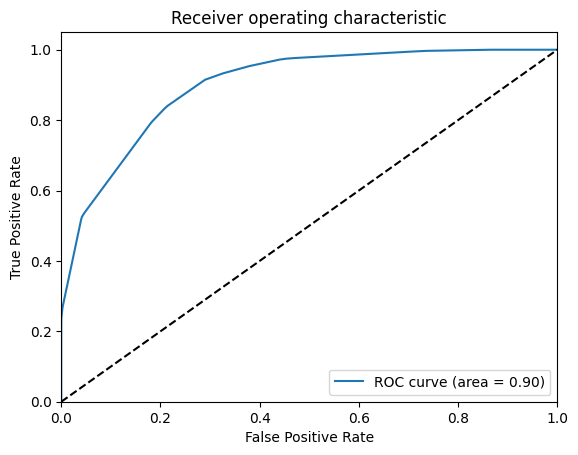

In [264]:
y_predicted_probe = clf.predict_proba(X_train)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, y_predicted_probe[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

#### Предсказание на тестовой выборке

In [265]:
predictions = clf.predict(X_test)
predictions

array([0., 0., 0., ..., 1., 0., 1.])

## б) Decision tree с автоматическим подбором параметров

In [242]:
clf = DecisionTreeClassifier()
clf

DecisionTreeClassifier()

In [243]:
parametrs = {'criterion':['gini', 'entropy'], 'max_depth':range(1, 30)}

In [244]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

In [245]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [246]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 9}

In [266]:
grid_search_cv_clf.best_score_

0.856269916225006

In [268]:
best_clf = grid_search_cv_clf.best_estimator_

In [251]:
best_clf.score(X_train, y_train)

0.8639476674549308

In [253]:
predictions = best_clf.predict(X_train)
predictions

array([0., 0., 0., ..., 0., 0., 1.])

In [254]:
# Метрики качества модели
accuracy = accuracy_score(y_train, predictions)
precision = precision_score(y_train, predictions)
recall = recall_score(y_train, predictions)
f1 = f1_score(y_train, predictions)

# Матрица ошибок
conf_matrix = confusion_matrix(y_train, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8639476674549308
Precision: 0.814725964200037
Recall: 0.5630659354674149
F1 Score: 0.6659125188536954
Confusion Matrix:
[[23716  1004]
 [ 3426  4415]]


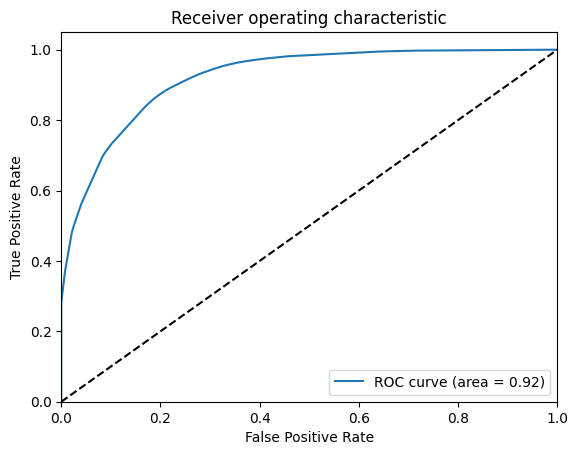

In [255]:
y_predicted_probe = best_clf.predict_proba(X_train)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, y_predicted_probe[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## В) Random forest с автоматическим подбором параметров